In [ ]:
#load library yang digunakan
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt;

import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout

In [ ]:
#load dataset
dataset= pd.read_csv('/content/sample_data/Asli 1 bulan.csv')

In [ ]:
dataset.head()

,Day,Date,Sessions,PageViews,Visitors,NewVisitors,Target
0,Monday,1/1/2018,3,3,3,3,2
1,Tuesday,1/2/2018,2,2,1,1,1
2,Wednesday,1/3/2018,1,1,1,1,1
3,Thursday,1/4/2018,1,1,1,1,2
4,Friday,1/5/2018,2,2,2,2,0


In [ ]:
dataset=dataset.drop('Day',axis=1);
dataset=dataset.drop('Date',axis=1);
dataset.head()

,Sessions,PageViews,Visitors,NewVisitors,Target
0,3,3,3,3,2
1,2,2,1,1,1
2,1,1,1,1,1
3,1,1,1,1,2
4,2,2,2,2,0


In [ ]:
values=dataset.values;

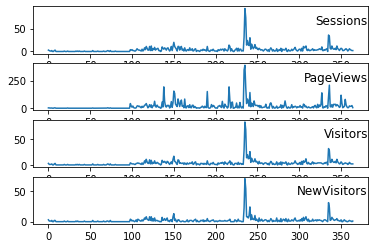

In [ ]:
# specify columns to plot
groups = [ 0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
values.shape

(730, 5)

In [ ]:
values.dtype

dtype('int64')

In [ ]:
#normalisasi
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
#covert to time-series
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
#frame sebagai supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.020134   0.006237      0.024   0.032258   0.013423  0.013423  0.004158   
2   0.013423   0.004158      0.008   0.010753   0.006711  0.006711  0.002079   
3   0.006711   0.002079      0.008   0.010753   0.006711  0.006711  0.002079   
4   0.006711   0.002079      0.008   0.010753   0.013423  0.013423  0.004158   
5   0.013423   0.004158      0.016   0.021505   0.000000  0.000000  0.000000   

   var3(t)   var4(t)   var5(t)  
1    0.008  0.010753  0.006711  
2    0.008  0.010753  0.006711  
3    0.008  0.010753  0.013423  
4    0.016  0.021505  0.000000  
5    0.000  0.000000  0.000000  


In [ ]:
#split into train and test sets
values = reframed.values
n_train = 365
train = values[:n_train, :]
test = values[n_train:, :]
#split into input and outputs
train_X, train_y = train[:, :5], train[:, 5]
test_X, test_y = test[:, :5], test[:, 5]

In [ ]:
#reshap input menjadi 3D ([)samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 1, 5) (365,) (364, 1, 5) (364,)


In [ ]:
#design network CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(MaxPool1D(pool_size=1))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(28, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(28, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='relu'))

model.compile(loss='mae', optimizer='RMSprop')

In [ ]:
model_path = '\best_model.h5'

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 64)             384       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 dropout_38 (Dropout)        (None, 1, 64)             0         
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 28)                1820      
                                                                 
 dropout_39 (Dropout)        (None, 28)                0         
                                                      

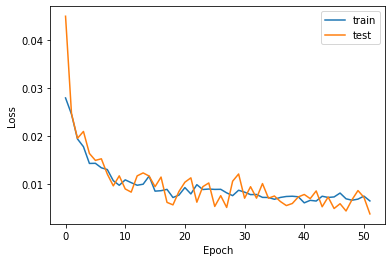

In [ ]:
#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

In [ ]:
#membuat prediksi training
xhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

#invert scaling untuk peramalan
inv_xhat = concatenate((xhat, train_X[:, 1:]), axis=1)
inv_xhat = scaler.inverse_transform(inv_xhat)
inv_xhat = inv_xhat[:,0]

#invert scaling untuk aktual
train_y = train_y.reshape((len(train_y), 1))
inv_x = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_x = scaler.inverse_transform(inv_x)
inv_x = inv_x[:,0]

In [ ]:
#membuat prediksi testing
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

#invert scaling untuk peramalan
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

#invert scaling untuk aktual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
#Evaluasi
rmse1 = sqrt(mean_squared_error(inv_x, inv_xhat))
print('Test RMSE Training: %.2f' % rmse1)
rmse2 = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE Testing: %.2f' % rmse2)
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.2f' % mse)
mape = (mean_absolute_percentage_error(yhat, test_y))
print('Test MAPE: %.2f' % mape)

Test RMSE Training: 0.79
Test RMSE Testing: 1.26
Test MSE: 1.58
Test MAPE: 1.16


Actual : [  1.   0.   2.   1.   1.   3.   4.   4.   7.   6.   0.   1.   3.   3.
   4.   4.   5.   1.   0.   4.   5.   0.   5.   4.   0.   1.   3.   4.
   2.   6.   8.   5.   5.   1.   2.   6.  12.   3.   4.   1.   3.   6.
   3.   3.   8.   3.   2.   4.   3.   5.   3.  11.   1.   0.  12.   2.
  10.   9.   2.   4.   1.  20.   5.   5.   4.   2.   2.   0.   4.   5.
   1.   5.   5.   6.   4.   5.   2.   4.   3.   0.   2.   2.   7.   3.
   2.   3.   2.   2.   2.  11.  15.   7.  10.   7.  11.   5.  29.   8.
   5.   9.   7.   2.   4.   8.   4.   3.   2.   3.   2.   2.  11.   7.
   2.   7.   4.   3.   3.   3.   2.   3.   3.   1.   3.   4.   2.   8.
   6.   6.   4.   5.   5.   5.   9.   2.   4.   4.  10.   8.  29.   2.
   3.   4.   3.   5.   4.   4.   7.  17.   2.   3.   1.   9.   5.   2.
   1.   2.   1.   2.   1.   3.   2.   4.   7.   6.   7.   4.   6.   5.
   9.   6.   7.   2. 149.  44.  21.  16.  16.   4.   5.   4.  20.   9.
  13.  11.  10.   6.   6.   4.  10.   6.   7.   2.   2.   5.   4.  1

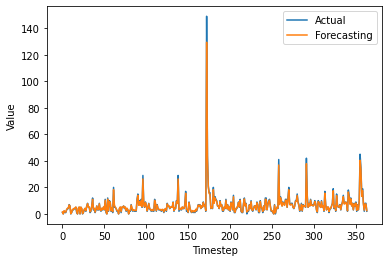

In [ ]:
print('Actual :', inv_y)
print('Predicted:', inv_yhat)
# plot history
pyplot.plot(inv_y, label='Actual')
pyplot.plot(inv_yhat, label='Forecasting')
pyplot.xlabel('Timestep')
pyplot.ylabel('Value')
pyplot.legend()
pyplot.show()